In [28]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import contextily as cx
from shapely.geometry import *
from descartes import *
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

print(gpd.__version__)

0.8.1


# Data Gathering

The clearest data for this type of project is from the American Community Survey (ACS) data from the Census Bureau. The ACS 5-year data provides a detailed look into neighborhood data through small areas called census tracts. First, I will focus on a larger picture of Milwaukee County that distinguishes between the various cities and towns in the county of Milwaukee. After mapping the county, I will focus on neighborhoods that have the most segregated populations. 

The data were obtained from the NHGIS

  Steven Manson, Jonathan Schroeder, David Van Riper, Tracy Kugler, and Steven Ruggles. IPUMS National Historical Geographic Information System: Version 15.0 [dataset]. Minneapolis, MN: IPUMS. 2020. http://doi.org/10.18128/D050.V15.0

First, load the census block data with pd,read_csv then create a function for the specific Milwaukee census blocks

In [2]:
census_blocks = pd.read_csv('Milwaukee/nhgis0001_csv/blocks.csv', encoding='latin-1')

In [3]:
mke_blocks = census_blocks.loc[census_blocks['COUNTY'] == 'Milwaukee County']

Next, we'll take a look at the data

In [4]:
mke_blocks.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AJWNM010,AJY4M001,AJY4M002,AJY4M003,AJY4M004,AJY4M005,AJY4M006,AJY4M007,AJY4M008,AJZAM001
1858,G55007900001011,2014-2018,NaN,NaN,Wisconsin,55,Milwaukee County,79,NaN,NaN,...,78,495,95,94,8,65,282,45,349,16379.0
1859,G55007900001012,2014-2018,NaN,NaN,Wisconsin,55,Milwaukee County,79,NaN,NaN,...,9,511,479,83,9,9,19,9,190,NaN
1860,G55007900001013,2014-2018,NaN,NaN,Wisconsin,55,Milwaukee County,79,NaN,NaN,...,9,284,116,198,34,9,143,9,210,7226.0
1861,G55007900001014,2014-2018,NaN,NaN,Wisconsin,55,Milwaukee County,79,NaN,NaN,...,36,379,173,23,146,112,86,9,328,23832.0
1862,G55007900001021,2014-2018,NaN,NaN,Wisconsin,55,Milwaukee County,79,NaN,NaN,...,8,358,200,131,20,212,13,106,199,13271.0


In [5]:
mke_blocks.head().T

,1858,1859,1860,1861,1862
GISJOIN,G55007900001011,G55007900001012,G55007900001013,G55007900001014,G55007900001021
YEAR,2014-2018,2014-2018,2014-2018,2014-2018,2014-2018
REGIONA,NaN,NaN,NaN,NaN,NaN
DIVISIONA,NaN,NaN,NaN,NaN,NaN
STATE,Wisconsin,Wisconsin,Wisconsin,Wisconsin,Wisconsin
...,...,...,...,...,...
AJY4M005,65,9,9,112,212
AJY4M006,282,19,143,86,13
AJY4M007,45,9,9,9,106
AJY4M008,349,190,210,328,199


In [6]:
blocks_map = gpd.read_file('Milwaukee/WI_blck_shape/WI_grp/WI_blck_grp_2018.shp')

In [7]:
blocks_map.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G55000109501001,55,001,950100,1,550019501001,Block Group 1,G5030,S,136277415.0,1064185.0,+44.2078382,-089.6813713,56148.326341,1.373416e+08,"POLYGON ((510084.115 762123.873, 509284.686 76..."
1,G55000109501002,55,001,950100,2,550019501002,Block Group 2,G5030,S,53694268.0,1721527.0,+44.1651437,-089.7758866,39435.926886,5.541581e+07,"POLYGON ((498976.504 761338.047, 497960.073 76..."
2,G55000109501003,55,001,950100,3,550019501003,Block Group 3,G5030,S,44004454.0,14737511.0,+44.2159173,-089.8643099,38855.124319,5.874198e+07,"POLYGON ((492948.296 766918.393, 492956.201 76..."
3,G55000109502011,55,001,950201,1,550019502011,Block Group 1,G5030,S,110142594.0,7642055.0,+44.0031471,-089.8876764,69751.363008,1.177846e+08,"POLYGON ((500128.615 741990.503, 499225.359 74..."
4,G55000109502021,55,001,950202,1,550019502021,Block Group 1,G5030,S,243738572.0,4925210.0,+44.0479706,-089.7327851,99403.807908,2.486638e+08,"POLYGON ((511369.951 742768.283, 510102.179 74..."


In [8]:
blocks_map.tail()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
4470,G55014100117001,55,141,011700,1,551410117001,Block Group 1,G5030,S,1114163.0,332433.0,+44.3434052,-089.8580790,5564.234550,1.446596e+06,"POLYGON ((488277.065 782437.688, 488355.585 78..."
4471,G55014100117002,55,141,011700,2,551410117002,Block Group 2,G5030,S,6534566.0,640689.0,+44.3489591,-089.8729459,14061.857600,7.175257e+06,"POLYGON ((488277.065 782437.688, 488250.610 78..."
4472,G55014100117003,55,141,011700,3,551410117003,Block Group 3,G5030,S,8037376.0,336045.0,+44.3312203,-089.9116788,13648.264771,8.373419e+06,"POLYGON ((485854.544 781500.956, 485867.594 78..."
4473,G55014100117004,55,141,011700,4,551410117004,Block Group 4,G5030,S,2722014.0,0.0,+44.3175391,-089.9124054,7949.799671,2.722011e+06,"POLYGON ((485515.753 778309.504, 485495.972 77..."
4474,G55014100117005,55,141,011700,5,551410117005,Block Group 5,G5030,S,5896106.0,354225.0,+44.3057606,-089.9089622,11836.714361,6.250327e+06,"POLYGON ((485829.587 778206.529, 485748.860 77..."


In [9]:
blocks_map.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

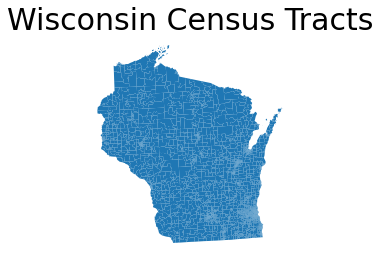

In [10]:
blocks_map.plot()

plt.title('Wisconsin Census Tracts', fontsize=30)
plt.axis('off');

In [11]:
cols = ['GISJOIN', 'AJWNE001', 'AJWNE002', 'AJWNE003', 'AJWNE004', 'AJWNE005', 'AJWNE006', 'AJWNE007', 'AJWNE008', 'AJWNE009', 'AJWNE010']

In [12]:
places = gpd.read_file('Milwaukee/cb_2019_55_place_500k/cb_2019_55_place_500k.shp')

In [13]:
places.head()

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,55,33225,01583365,1600000US5533225,5533225,Haugen,47,1305540,15109,"POLYGON ((-91.78605 45.61354, -91.77649 45.613..."
1,55,45425,01583592,1600000US5545425,5545425,Lohrville,47,3144833,26874,"POLYGON ((-89.13354 44.04090, -89.12850 44.040..."
2,55,60250,01583869,1600000US5560250,5560250,Orfordville,47,3073273,0,"POLYGON ((-89.27208 42.63316, -89.26843 42.633..."
3,55,66450,01584000,1600000US5566450,5566450,Readstown,47,4432324,53689,"POLYGON ((-90.77216 43.44552, -90.77239 43.452..."
4,55,87975,01584459,1600000US5587975,5587975,Winter,47,2051266,0,"POLYGON ((-91.02346 45.82704, -91.00779 45.826..."


## Set Map Projection

After failed attempts to set the map projection, I decided to leave the map askew. The geo dataframe is missing the necessary crs information

In [14]:
milwaukee = places[places['NAME'] == 'Milwaukee']

In [15]:
milwaukee

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
96,55,53000,01583724,1600000US5553000,5553000,Milwaukee,25,249114740,1634105,"MULTIPOLYGON (((-88.06713 43.19475, -88.06338 ..."


<AxesSubplot:>

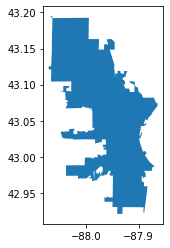

In [16]:
milwaukee.plot()

In [17]:
milwaukee_blocks = mke_blocks[mke_blocks['COUNTYA'] == 79] 

## Combine shape and race data

In [18]:
mke_blocks_map = blocks_map.merge(milwaukee_blocks.loc[:, cols],
                                  how='inner',
                                  on='GISJOIN',
                                  validate='one_to_one')

In [19]:
milwaukee.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [20]:
mke_blocks_map = mke_blocks_map.to_crs('EPSG:7613')

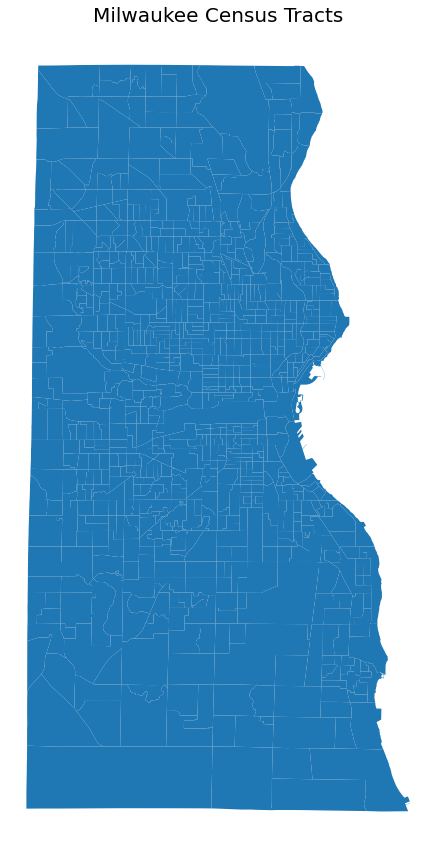

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
mke_blocks_map.plot(ax=ax)
ax.set_title('Milwaukee Census Tracts', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
plt.savefig('crs.png')

# Plot Choropleth

## Race/Ethinicity codes:

        AJWNE001:    Total
        AJWNE002:    White alone
        AJWNE003:    Black or African American alone
        AJWNE004:    American Indian and Alaska Native alone
        AJWNE005:    Asian alone
        AJWNE006:    Native Hawaiian and Other Pacific Islander alone
        AJWNE007:    Some other race alone
        AJWNE008:    Two or more races
        

In [22]:
mke_blocks_map

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,AJWNE001,AJWNE002,AJWNE003,AJWNE004,AJWNE005,AJWNE006,AJWNE007,AJWNE008,AJWNE009,AJWNE010
0,G55007900001011,55,079,000101,1,550790001011,Block Group 1,G5030,S,1348418.0,...,1609,486,754,0,31,0,205,133,83,50
1,G55007900001012,55,079,000101,2,550790001012,Block Group 2,G5030,S,1308617.0,...,853,96,757,0,0,0,0,0,0,0
2,G55007900001013,55,079,000101,3,550790001013,Block Group 3,G5030,S,779079.0,...,1067,423,566,0,33,0,45,0,0,0
3,G55007900001014,55,079,000101,4,550790001014,Block Group 4,G5030,S,381483.0,...,947,116,802,0,0,0,7,22,0,22
4,G55007900001021,55,079,000102,1,550790001021,Block Group 1,G5030,S,997669.0,...,1326,260,1036,0,0,0,0,30,26,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,G55007901873001,55,079,187300,1,550791873001,Block Group 1,G5030,S,2163435.0,...,1247,1121,32,56,38,0,0,0,0,0
854,G55007901873002,55,079,187300,2,550791873002,Block Group 2,G5030,S,2431216.0,...,2605,2364,0,0,42,0,149,50,0,50
855,G55007901873003,55,079,187300,3,550791873003,Block Group 3,G5030,S,3206234.0,...,2948,2275,0,0,464,0,16,193,15,178
856,G55007901874001,55,079,187400,1,550791874001,Block Group 1,G5030,S,1579703.0,...,3371,2844,141,8,161,0,11,206,158,48


In [23]:
mke_blocks_map['white_rate'] = mke_blocks_map['AJWNE002'] / mke_blocks_map['AJWNE001']

In [24]:
mke_blocks_map['black_rate'] = mke_blocks_map['AJWNE003'] / mke_blocks_map['AJWNE001']

In [29]:
mke_street_map = cx.Place('Milwaukee, WI', path='milwaukee.tif')

In [38]:
mke_street_map

Place : Milwaukee, Milwaukee County, Wisconsin, United States of America | n_tiles: 1 | zoom : 12 | im : (1280, 1024)

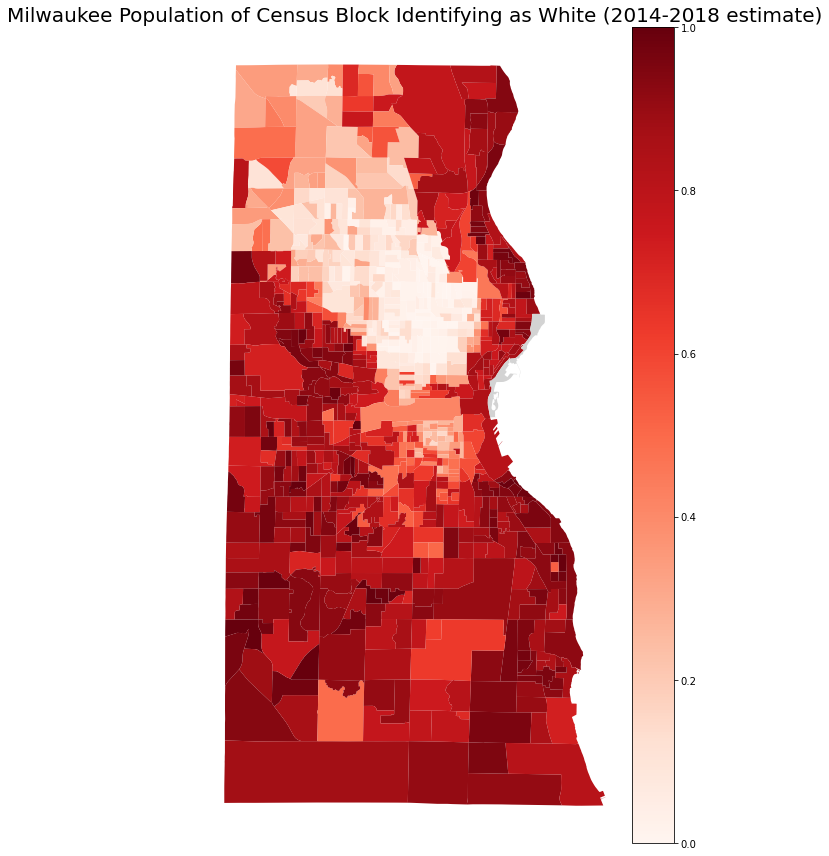

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.1)
mke_blocks_map.plot(ax=ax,
                   column='white_rate',
                    cmap='Reds',
                    legend=True,
                    cax=cax,
                    missing_kwds={"color": "lightgrey"},
                    )
ax.set_title('Milwaukee Population of Census Block Identifying as White (2014-2018 estimate)', fontsize=20)
ax.axis('off')
plt.tight_layout()
plt.savefig('mke_choropleth.png')

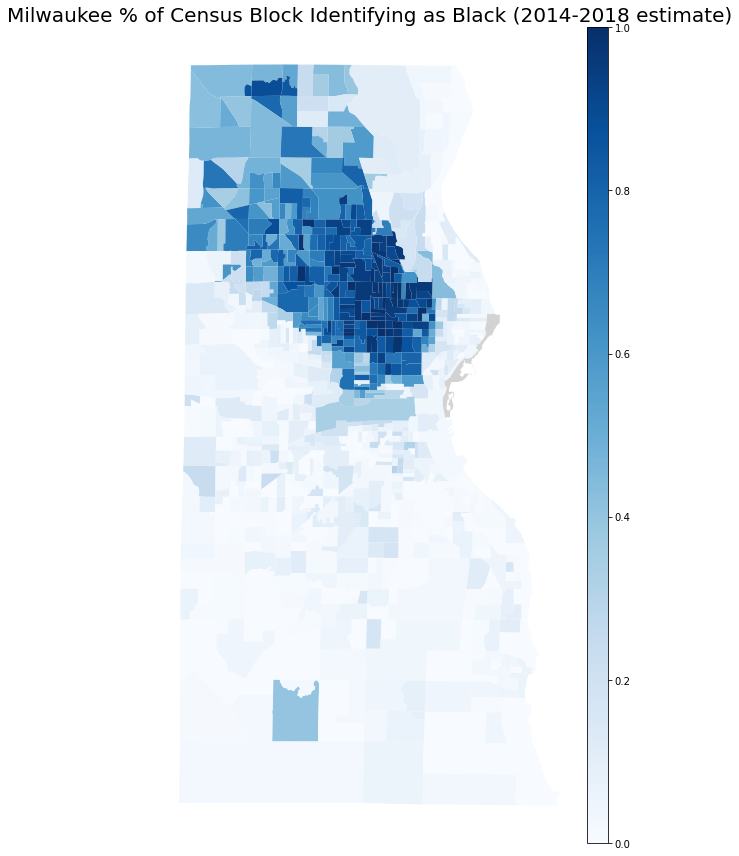

In [26]:
fig, ax = plt.subplots(figsize=(12,12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
mke_blocks_map.plot(ax=ax,
                   column='black_rate',
                   cmap='Blues',
                   legend=True,
                    cax=cax,
                    missing_kwds={"color": "lightgrey"}
                   )
ax.set_title('Milwaukee % of Census Block Identifying as Black (2014-2018 estimate)', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
plt.savefig('mke_choropleth_black.png')

We can see the high density of residents identifying as black in a grouping of census blocks. Focusing on those census blocks, we will: 
1) identify which census blocks report over 70% population of those identifying as black, 
2) map the median income values for those census blocks, 
3) show the median home values  

In [35]:
race_gdf = gpd.read_file('Milwaukee/WI_blck_grp_race/WI_blck_grp_2018.shp')

In [37]:
race_gdf.head().T

,0,1,2,3,4
GISJOIN,G55000109501001,G55000109501002,G55000109501003,G55000109502011,G55000109502021
STATEFP,55,55,55,55,55
COUNTYFP,001,001,001,001,001
TRACTCE,950100,950100,950100,950201,950202
BLKGRPCE,1,2,3,1,1
GEOID,550019501001,550019501002,550019501003,550019502011,550019502021
NAMELSAD,Block Group 1,Block Group 2,Block Group 3,Block Group 1,Block Group 1
MTFCC,G5030,G5030,G5030,G5030,G5030
FUNCSTAT,S,S,S,S,S
ALAND,1.36277e+08,5.36943e+07,4.40045e+07,1.10143e+08,2.43739e+08
